In [15]:
%matplotlib inline

import dlc_practical_prologue as prologue
import torch.nn as nn
import torch

import matplotlib.pyplot as plt

In [44]:
#a very naive model taking input as the flattened version of two images
#and running them through connected layers
#the output is 2 dimensional since we aim to optimize for the target boolean value

#we return (none, none, ...) to make it compatible with our training procedure

class FNN1(torch.nn.Module):
    def __init__(self):
        super(FNN1, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(2*196, 196),
            nn.ReLU(),
            nn.Linear(196,196),
            nn.ReLU(),
            nn.Linear(196, 98),
            nn.ReLU(),
            nn.Linear(98, 2),
            nn.Sigmoid()
        )
        

            
    #this takes (Batch,14,14) input im1, im2
    def forward(self, im1, im2):
        concatted = torch.cat([im1,im2], dim = 1).view(-1, 2*196)
        return None, None, self.model(concatted)

In [54]:
#here the self.model is used for recognizing the digits in each images --10 digits
#self.predictor is for predicting the target
#since both digits are computed with self.model, this could be an example of weight sharing
#also, note we return (d1,d2,target) so this is an example of auxillary loss (check the training)
class FNN2(torch.nn.Module):
    def __init__(self):
        super(FNN2, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(196, 50),
            nn.ReLU(),
            nn.Linear(50,50),
            nn.ReLU(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1)
        )
        
        self.predictor = nn.Sequential(
            nn.Linear(20, 2),
            nn.Sigmoid()
        )
            
            
    #this takes (Batch,14,14) input im1, im2
    def forward(self, im1, im2):
        d1 = self.model(im1.view(-1, 196))
        d2 = self.model(im2.view(-1, 196))
        concatted = torch.cat([d1,d2], dim = 1)
        target = self.predictor(concatted)
        return d1,d2,target

In [55]:
#same model as above but note we return None,None
#this is an example without the auxillary loss (check the training)
class FNN3(torch.nn.Module):
    def __init__(self):
        super(FNN3, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(196, 50),
            nn.ReLU(),
            nn.Linear(50,50),
            nn.ReLU(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1)
        )
        
        self.predictor = nn.Sequential(
            nn.Linear(20, 2),
            nn.Sigmoid()
        )
            
            
    #this takes (Batch,14,14) input im1, im2
    def forward(self, im1, im2):
        d1 = self.model(im1.view(-1, 196))
        d2 = self.model(im2.view(-1, 196))
        concatted = torch.cat([d1,d2], dim = 1)
        target = self.predictor(concatted)
        return None, None, target

In [4]:
# Load the data
size = 1000
train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(size)


#normalization
#check https://stats.stackexchange.com/questions/174823/
mu, std = train_input.mean(), train_input.std()
train_input, test_input = train_input.sub(mu).div(std), test_input.sub(mu).div(std)

#split the images
train_input1, train_input2 = train_input[:, 0, :, :], train_input[:, 1, :, :] 
test_input1, test_input2 = test_input[:, 0, :, :], test_input[:, 1, :, :] 

#split the number pairs
train_classes1, train_classes2 = train_classes[:, 0], train_classes[:, 1]
test_classes1, test_classes2 = test_classes[:, 0], test_classes[:, 1]

In [5]:
model = FNN1()
model2 = FNN2()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer2 = torch.optim.SGD(model2.parameters(), lr=0.01, momentum=0.9)

criterion = nn.CrossEntropyLoss()
batch_size = 5
nb_epochs = 500

In [6]:
#inputs the values in the cell above
def train_model(mdl , nb_epochs, batch_size, optimizer, criterion):
    # dictionary to return whatever value we wanna return e.g. loss at each epoch (useful for plotting)
    model_history = dict()
    
    #a list to keep track of the losses at each epoch
    loss_history = []
    for e in range(nb_epochs):
        loss = 0
        for b in range(0, train_input.size(0), batch_size):

            #slice the part of the minibatch that is of interest
            train_1 = train_input1[b: b + batch_size]
            train_2 = train_input2[b: b + batch_size]
            
            #retrieve also their digit information
            classes_1 = train_classes1[b: b + batch_size]
            classes_2 = train_classes2[b: b + batch_size]
            
            #finally, retrieve the predicted boolean
            real_targets =  train_target[b:b + batch_size]
            
            
            #send a minibatch of two images to some model
            #d1,d2,pred are the predicted values
            #note that depending on the model d1,d2 can be None
            
            d1, d2, pred = mdl(train_1, train_2)
            
            
            # compute the loss against the boolean value
            pred_loss =  criterion(pred.view(-1, 2), real_targets)
            
            #this is where auxillary loss happens
            #if you return from the model a triple such as (None,None,pred)
            #the following line won't make use of the digit information
            #if you return the guessed digits however as in FNN2
            # it will be added to the loss and the gradients will change with respect to that.
            if d1 is not None:
                pred_loss += criterion(d1.view(-1, 10), classes_1)
                pred_loss += criterion(d2.view(-1, 10), classes_2)
                pred_loss /= 3
            
            loss += pred_loss.item() 
            
            # Reinitialize to 0 the gradients
            mdl.zero_grad()
            
            # Backward pass
            
            #this calls every backward inside this loss
            pred_loss.backward()
            
            # Update
            optimizer.step()
            
        print("epoch =", e, ", loss = ",loss)
        loss_history.append(loss)
        
    model_history['loss_history'] = loss_history
    
    return model_history
    
  
        

In [7]:
def compute_nb_errors(model):
    # Prediction
    d1,d2,pred = model(test_input1, test_input2)
    _, indices = torch.max(pred.view(-1,2), 1) # along dim1
    
    acc_d1, acc_d2 = None, None
    
    if d1 is not None:
        _, indices1 = torch.max(d1.view(-1,10), 1)
        _, indices2 = torch.max(d2.view(-1,10), 1)
        acc_d1 = (sum(indices1 == test_classes1) / float(size) * 100).item()
        acc_d2 = (sum(indices2 == test_classes2) / float(size) * 100).item()
    
    acc_target = (sum(indices == test_target) / float(size) * 100).item()

    return (acc_target, acc_d1, acc_d2)

  

In [8]:
hist = train_model(model, nb_epochs,batch_size, optimizer, criterion)

epoch = 0 , loss =  134.80971723794937
epoch = 1 , loss =  110.9453085064888
epoch = 2 , loss =  102.69632914662361
epoch = 3 , loss =  99.03172841668129
epoch = 4 , loss =  91.81093382835388
epoch = 5 , loss =  86.75466558337212
epoch = 6 , loss =  85.75595185160637
epoch = 7 , loss =  84.8974481523037
epoch = 8 , loss =  80.28523537516594
epoch = 9 , loss =  82.77483686804771
epoch = 10 , loss =  84.00284883379936
epoch = 11 , loss =  78.08368727564812
epoch = 12 , loss =  77.43149876594543
epoch = 13 , loss =  76.46723818778992
epoch = 14 , loss =  75.80388140678406
epoch = 15 , loss =  75.6292445063591
epoch = 16 , loss =  74.556835770607
epoch = 17 , loss =  73.78737744688988
epoch = 18 , loss =  72.85883218050003
epoch = 19 , loss =  74.11940041184425
epoch = 20 , loss =  73.78853416442871
epoch = 21 , loss =  73.83815839886665
epoch = 22 , loss =  75.6944873034954
epoch = 23 , loss =  74.97523692250252
epoch = 24 , loss =  74.02394214272499
epoch = 25 , loss =  71.87062793970108

epoch = 209 , loss =  70.05737048387527
epoch = 210 , loss =  71.30958715081215
epoch = 211 , loss =  70.01732435822487
epoch = 212 , loss =  71.8061351776123
epoch = 213 , loss =  69.5886844098568
epoch = 214 , loss =  68.57232916355133
epoch = 215 , loss =  68.5652785897255
epoch = 216 , loss =  67.75562351942062
epoch = 217 , loss =  67.65598666667938
epoch = 218 , loss =  67.45930209755898
epoch = 219 , loss =  67.45502996444702
epoch = 220 , loss =  67.4548405110836
epoch = 221 , loss =  67.45468834042549
epoch = 222 , loss =  67.45455771684647
epoch = 223 , loss =  67.4544450044632
epoch = 224 , loss =  67.45434555411339
epoch = 225 , loss =  67.45425641536713
epoch = 226 , loss =  67.4541762471199
epoch = 227 , loss =  67.45410335063934
epoch = 228 , loss =  67.45403656363487
epoch = 229 , loss =  67.45397582650185
epoch = 230 , loss =  67.45391929149628
epoch = 231 , loss =  67.45386675000191
epoch = 232 , loss =  67.45381808280945
epoch = 233 , loss =  67.45377278327942
epoch 

epoch = 415 , loss =  67.45255935192108
epoch = 416 , loss =  67.45255833864212
epoch = 417 , loss =  67.45255702733994
epoch = 418 , loss =  67.45255610346794
epoch = 419 , loss =  67.4525545835495
epoch = 420 , loss =  67.4525533914566
epoch = 421 , loss =  67.45255225896835
epoch = 422 , loss =  67.45255106687546
epoch = 423 , loss =  67.45254984498024
epoch = 424 , loss =  67.45254847407341
epoch = 425 , loss =  67.45254734158516
epoch = 426 , loss =  67.45254608988762
epoch = 427 , loss =  67.45254504680634
epoch = 428 , loss =  67.45254376530647
epoch = 429 , loss =  67.45254272222519
epoch = 430 , loss =  67.452541410923
epoch = 431 , loss =  67.45254036784172
epoch = 432 , loss =  67.45253905653954
epoch = 433 , loss =  67.45253786444664
epoch = 434 , loss =  67.45253682136536
epoch = 435 , loss =  67.45253565907478
epoch = 436 , loss =  67.45253443717957
epoch = 437 , loss =  67.45253348350525
epoch = 438 , loss =  67.45253214240074
epoch = 439 , loss =  67.45253118872643
epoc

In [10]:
hist2 = train_model(model2, nb_epochs, batch_size, optimizer2, criterion)

epoch = 0 , loss =  351.649297952652
epoch = 1 , loss =  334.02176225185394
epoch = 2 , loss =  295.4374887943268
epoch = 3 , loss =  279.5131324529648
epoch = 4 , loss =  274.3509830236435
epoch = 5 , loss =  271.64953196048737
epoch = 6 , loss =  269.7817476987839
epoch = 7 , loss =  268.349267244339
epoch = 8 , loss =  267.1677612066269
epoch = 9 , loss =  266.1572469472885
epoch = 10 , loss =  265.1536955833435
epoch = 11 , loss =  264.1555058956146
epoch = 12 , loss =  263.30253529548645
epoch = 13 , loss =  262.56757295131683
epoch = 14 , loss =  261.9168303012848
epoch = 15 , loss =  261.3461561203003
epoch = 16 , loss =  260.8305777311325
epoch = 17 , loss =  260.35004234313965
epoch = 18 , loss =  259.9477971792221
epoch = 19 , loss =  259.48805356025696
epoch = 20 , loss =  259.0445761680603
epoch = 21 , loss =  258.6673091650009
epoch = 22 , loss =  258.31487023830414
epoch = 23 , loss =  257.96015870571136
epoch = 24 , loss =  257.58944821357727
epoch = 25 , loss =  257.204

epoch = 205 , loss =  236.00438964366913
epoch = 206 , loss =  235.99768042564392
epoch = 207 , loss =  235.99243700504303
epoch = 208 , loss =  235.98395657539368
epoch = 209 , loss =  235.9709198474884
epoch = 210 , loss =  235.96643137931824
epoch = 211 , loss =  235.9633274078369
epoch = 212 , loss =  235.94644498825073
epoch = 213 , loss =  235.93404304981232
epoch = 214 , loss =  235.9359027147293
epoch = 215 , loss =  235.92378866672516
epoch = 216 , loss =  235.9107518196106
epoch = 217 , loss =  235.89691591262817
epoch = 218 , loss =  235.88499629497528
epoch = 219 , loss =  235.8790566921234
epoch = 220 , loss =  235.86596941947937
epoch = 221 , loss =  235.85594987869263
epoch = 222 , loss =  235.84697771072388
epoch = 223 , loss =  235.84076023101807
epoch = 224 , loss =  235.83762907981873
epoch = 225 , loss =  235.86247789859772
epoch = 226 , loss =  235.82881271839142
epoch = 227 , loss =  235.8120858669281
epoch = 228 , loss =  235.80920445919037
epoch = 229 , loss =  

epoch = 407 , loss =  226.95495808124542
epoch = 408 , loss =  226.6106779575348
epoch = 409 , loss =  226.5830523967743
epoch = 410 , loss =  226.72934901714325
epoch = 411 , loss =  226.46751165390015
epoch = 412 , loss =  226.2042510509491
epoch = 413 , loss =  226.073725938797
epoch = 414 , loss =  225.9392328262329
epoch = 415 , loss =  225.86615467071533
epoch = 416 , loss =  225.81985938549042
epoch = 417 , loss =  225.68468761444092
epoch = 418 , loss =  225.6448152065277
epoch = 419 , loss =  225.57948756217957
epoch = 420 , loss =  225.52962815761566
epoch = 421 , loss =  225.4813621044159
epoch = 422 , loss =  225.44019269943237
epoch = 423 , loss =  225.3941549062729
epoch = 424 , loss =  225.37276077270508
epoch = 425 , loss =  225.3371889591217
epoch = 426 , loss =  225.28684210777283
epoch = 427 , loss =  225.24702203273773
epoch = 428 , loss =  225.20505452156067
epoch = 429 , loss =  225.18294990062714
epoch = 430 , loss =  225.1532814502716
epoch = 431 , loss =  225.1

In [56]:
model3 = FNN3()
optimizer3 = torch.optim.SGD(model3.parameters(), lr=0.01, momentum=0.9)
hist3 = train_model(model3, nb_epochs, batch_size, optimizer3, criterion)

epoch = 0 , loss =  138.06988155841827
epoch = 1 , loss =  137.7095124721527
epoch = 2 , loss =  137.59051764011383
epoch = 3 , loss =  137.51150333881378
epoch = 4 , loss =  137.39990681409836
epoch = 5 , loss =  137.12578201293945
epoch = 6 , loss =  135.628744661808
epoch = 7 , loss =  130.96274316310883
epoch = 8 , loss =  124.82776391506195
epoch = 9 , loss =  118.1650964319706
epoch = 10 , loss =  112.34553760290146
epoch = 11 , loss =  108.78217926621437
epoch = 12 , loss =  106.82617363333702
epoch = 13 , loss =  104.91812485456467
epoch = 14 , loss =  102.77668762207031
epoch = 15 , loss =  102.91832742094994
epoch = 16 , loss =  99.93223738670349
epoch = 17 , loss =  98.03693351149559
epoch = 18 , loss =  96.20325535535812
epoch = 19 , loss =  94.9793084859848
epoch = 20 , loss =  93.71108970046043
epoch = 21 , loss =  92.05882492661476
epoch = 22 , loss =  90.97217130661011
epoch = 23 , loss =  90.5619707107544
epoch = 24 , loss =  89.37420332431793
epoch = 25 , loss =  88.8

epoch = 208 , loss =  65.8437610566616
epoch = 209 , loss =  65.84292539954185
epoch = 210 , loss =  65.84208044409752
epoch = 211 , loss =  65.84126117825508
epoch = 212 , loss =  65.84045147895813
epoch = 213 , loss =  65.83963081240654
epoch = 214 , loss =  65.83883678913116
epoch = 215 , loss =  65.83806693553925
epoch = 216 , loss =  65.83729812502861
epoch = 217 , loss =  65.83653593063354
epoch = 218 , loss =  65.83577236533165
epoch = 219 , loss =  65.83503067493439
epoch = 220 , loss =  65.83428901433945
epoch = 221 , loss =  65.83352237939835
epoch = 222 , loss =  65.83281669020653
epoch = 223 , loss =  65.83214727044106
epoch = 224 , loss =  65.83137780427933
epoch = 225 , loss =  65.83072617650032
epoch = 226 , loss =  65.82999747991562
epoch = 227 , loss =  65.82935446500778
epoch = 228 , loss =  65.82862648367882
epoch = 229 , loss =  65.82794481515884
epoch = 230 , loss =  65.82732152938843
epoch = 231 , loss =  65.82662734389305
epoch = 232 , loss =  65.82597374916077
e

epoch = 414 , loss =  65.75869011878967
epoch = 415 , loss =  65.75846064090729
epoch = 416 , loss =  65.75824818015099
epoch = 417 , loss =  65.75802308320999
epoch = 418 , loss =  65.75780433416367
epoch = 419 , loss =  65.75758627057076
epoch = 420 , loss =  65.75736859440804
epoch = 421 , loss =  65.75715002417564
epoch = 422 , loss =  65.75693964958191
epoch = 423 , loss =  65.75672167539597
epoch = 424 , loss =  65.75651091337204
epoch = 425 , loss =  65.75629475712776
epoch = 426 , loss =  65.75608029961586
epoch = 427 , loss =  65.75586634874344
epoch = 428 , loss =  65.75566282868385
epoch = 429 , loss =  65.75544801354408
epoch = 430 , loss =  65.75524261593819
epoch = 431 , loss =  65.75503197312355
epoch = 432 , loss =  65.75482439994812
epoch = 433 , loss =  65.75462087988853
epoch = 434 , loss =  65.75441613793373
epoch = 435 , loss =  65.75420847535133
epoch = 436 , loss =  65.75400087237358
epoch = 437 , loss =  65.75380596518517
epoch = 438 , loss =  65.75359606742859


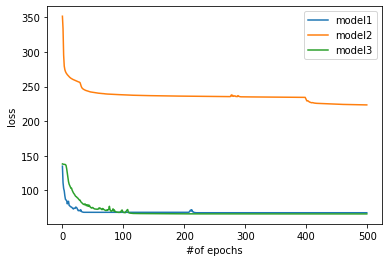

In [63]:
histories = [hist, hist2,hist3]
def plotLoss(histories, x_label, y_label, line_labels):
    losses = [hist['loss_history'] for hist in histories]
    for l,n in zip(losses,line_labels):
        plt.plot(l, label = n)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.show()
    
plotLoss(histories, '#of epochs', 'loss', ['model1', 'model2','model3'])
#note that model2 make use of auxillary loss (d1+d2+predicted) so it has more loss in magnitude
#but it performs better as you can check below

In [40]:
compute_nb_errors(model) #accuracy percentage

(78.19999694824219, None, None)

In [43]:
compute_nb_errors(model2)#accuracy percentage

(92.4000015258789, 90.80000305175781, 89.0999984741211)

In [60]:
compute_nb_errors(model3)#accuracy percentage

(71.80000305175781, None, None)

### IDEAS:
## Define a model of your preference if you think it can be mentioned in some detail in the report. We can aim for the best performing model by checking the hyperparameters from the last year's work, or we can just come up with other models to say we conducted experiments on this and that, such as the effect of batch size, learning rate, different kind of optimizers. 

## Also, I haven't seen a validation set in Kenyu's code so I did not make use of that too. However, if you think we should make use of a validation set, split the training set further maybe with 80% 20% train-validation portions. It would be nice to visualize the validation loss along with the training loss so you may have to modify the training function in that case to keep track of the validation loss.